In [748]:
# This code tests the trained 3d dq stepper
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#for live plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

%run cent_env.ipynb #imports LIPM Env

In [749]:
# Lipm - 8 layers , 512 each
class NN(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN, self).__init__()
        self.l1 = nn.Linear(inp_size, 512)
        self.l2 = nn.Linear(512, 512)
        self.l3 = nn.Linear(512, 512)
        self.l4 = nn.Linear(512, 512)
        self.l5 = nn.Linear(512, 512)
        self.l6 = nn.Linear(512, 512)
        self.l7 = nn.Linear(512, 512)
        self.l8 = nn.Linear(512, 512)
        self.l9 = nn.Linear(512, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        x = F.relu(self.l6(x))
        x = F.relu(self.l7(x))
        x = F.relu(self.l8(x))
        x = self.l9(x)
        return x

In [750]:
class DQStepper:
    def __init__(self, env, lr = 1e-4, gamma = 0.9, use_tarnet = False, trained_model = None):
        '''
        This is a 3d dq stepper.
        State = [x-ux, y-uy, z-uz, xd, yd, n, action_x, action_y, action_z]
        '''
        self.device = torch.device("cpu")
        self.dq_stepper = NN(11, 1).to(self.device) #state+ action -> q_value
        if trained_model:
            self.dq_stepper.load_state_dict(torch.load(trained_model))
            self.dq_stepper.eval()
        self.optimizer = torch.optim.SGD(self.dq_stepper.parameters(), lr)
        self.use_tarnet = use_tarnet
        if self.use_tarnet:
            self.dq_tar_stepper = NN(11, 1).to(self.device)
            self.dq_tar_stepper.load_state_dict(self.dq_stepper.state_dict())
            self.dq_tar_stepper.eval()
        self.gamma = gamma #discount factor
        self.no_actions = env.no_actions
        
        # This is the template of x_in that goes into the dq stepper
        self.max_step_height = 0.00
        self.max_no = 5 #number of actions with non zero step in z
        self.x_in = np.zeros((self.no_actions[0]*self.no_actions[1], 11))
        self.x_in[:,8] = np.tile(np.arange(self.no_actions[0]), self.no_actions[1])
        self.x_in[:,9] = np.repeat(np.arange(self.no_actions[1]), self.no_actions[0])
        
    def predict_action_value(self, x):
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        for e in np.random.randint(0, len(self.x_in), self.max_no):
            self.x_in[e, 10] = 2*self.max_step_height*(np.random.rand() - 0.5)
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
        return [action_x, action_y, action_z], q_values[action_index]
    
    def tar_predict_action_value(self, x):
        # this function uses tar net to predict 
        # the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        for e in np.random.randint(0, len(self.x_in), self.max_no):
            self.x_in[e, 10] = 2*self.max_step_height*(np.random.rand() - 0.5)
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_tar_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
        return [action_x, action_y, action_z], q_values[action_index]
    
    def predict_eps_greedy(self, x, eps = 0.1):
        # This function returns prediction based on epsillon greedy algorithm
        if np.random.random() > eps:
            return self.predict_action_value(x)[0]
        else:
            action_x = np.random.randint(self.no_actions[0])
            action_y = np.random.randint(self.no_actions[1])
            action_z = 2*self.max_step_height*(np.random.rand() - 0.5)
            
        return [action_x, action_y, action_z]
        
    def optimize(self, mini_batch, tau = 0.001):
        # This function performs one step of back propogation for the given mini_batch data
        x_in = torch.FloatTensor(mini_batch[:,0:11].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,11].copy(), device = self.device)
        for i in range(len(mini_batch)):
            if not np.isnan(mini_batch[i,12:]).all():
                if not self.use_tarnet:
                    y_train[i] += self.gamma * self.predict_action_value(mini_batch[i,12:])[1]
                else:
                    y_train[i] += self.gamma * self.tar_predict_action_value(mini_batch[i,12:])[1]

        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dq_stepper(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.use_tarnet:
            for tar_param, param in zip(self.dq_tar_stepper.parameters(), self.dq_stepper.parameters()):
                tar_param.data.copy_(tar_param.data * (1.0 - tau) + param.data * tau)
                
        return loss
    
    def live_plot(self, history, e, figsize=(15,25), window = 500, title='history'):
        clear_output(wait=True)
        fig, ax = plt.subplots(3, 1, figsize=figsize)
        ax[0].plot(history['epi_cost'], label='epi_cost', color = 'orange')
        ax[0].grid(True)
        ax[0].legend() # the plot evolves to the right
        if e > window:
            ax[1].plot(np.arange(e-window+1, e), history['epi_cost'][e-window:], label='epi_cost zoom')
            ax[1].grid(True)
            ax[1].legend() # the plot evolves to the right
        ax[2].plot(history['loss'], label='loss', color = 'black')
        ax[2].grid(True)
        ax[2].legend() # the plot evolves to the right
        ax[2].set_ylim(0, 60)
        plt.xlabel('episode')
        plt.show();
        
    def predict_q(self, x, terrain):
        #for debugging
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6, 7]] = x
        self.x_in[:,10] = terrain
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
            action_z = self.x_in[action_index,10]
            
        return q_values, [action_x, action_y, action_z] 

In [752]:
ht = 0.26
step_time = 0.1
air_time = 0.1
env = CentEnv(ht, 0.13, 0.5, [2.5, 3.0, 0.5], [1,9])
print(env.action_space_y)
dqs = DQStepper(env, lr=1e-4, gamma=0.98, use_tarnet= True, trained_model='../../models/dqs_1')

[0.   0.04 0.09 0.13 0.18 0.24 0.34 0.46 0.63]


In [760]:
no_steps = 20 ## number of steps simulated per episode (pendulum steps)

v_des = [0.0, 0]
v_init = [0.0*(np.random.rand() - 0.5), 1.0*(np.random.rand() - 0.5)]
# v_init = [.0, 0.0]
print(v_init)
state = env.reset_env([0.0, -0.035, ht, v_init[0], v_init[1], 0.0], v_des, no_steps*(2*step_time + air_time))
epi_cost = 0
for n in range(no_steps):
    terrain = 0.00
    action = dqs.predict_q(state, terrain)[1]
    next_state, cost, done = env.step_env(action, step_time, air_time)
    print(action, cost, done, state[3:5])
    epi_cost += cost
    state = next_state
    if done:
        print(epi_cost)
        break
print("showing episode...")
# env.show_episode(5)
# env.show_episode_side(5)

[0.0, 0.48141336288951164]
[0, 6, 0.0] 0.34 False [0.         0.48141336]
[0, 6, 0.0] 2.19 False [ 0.         -0.02470633]
[0, 3, 0.0] 107.94 True [ 0.         -0.64405522]
110.47
showing episode...


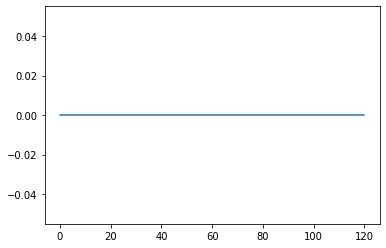

In [1078]:
# plt.plot(env.sim_data[7])

In [742]:
ht = 0.24

b = 0.13
step_time = 0.1
air_time = 0.1
actions = [11, 11]
max_step_length = [0.5, 0.5]

env_main = CentEnv(ht, 0.13, 0.5, [0.5, 3.0, 1.5], actions)

env_x = CentEnv(ht, 0., max_step_length[0], [0.5, 3.0, 1.5], [actions[0],1])
dqs_x = DQStepper(env_x, lr=1e-4, gamma=0.98, use_tarnet= True, trained_model='../../models/dqs_1_str')
env_y = CentEnv(ht, b, max_step_length[1], [0.5, 3.0, 1.5], [1,actions[1]])
dqs_y = DQStepper(env_y, lr=1e-4, gamma=0.98, use_tarnet= True, trained_model='../../models/dqs_1_side')
print(env_y.action_space_y)

[-0.37 -0.27 -0.17 -0.07  0.03  0.13  0.23  0.33  0.43  0.53  0.63]


In [747]:
no_steps = 20 ## number of steps simulated per episode (pendulum steps)

v_des = [0., 0]
# v_init = [3.0*(np.random.rand() - 0.5), 2*(np.random.rand() - 0.5)]
v_init = [0.0, -0.0]
print(v_init)
state = env_main.reset_env([0.0, -0.05, ht, v_init[0], v_init[1], 0.0], v_des, no_steps*(2*step_time + air_time))
epi_cost = 0
for n in range(no_steps):
    terrain = 0.00
    # for x axis
    state_x = state.copy()
    state_x[1] = 0.0
    state_x[4] = 0.0
    state_x[7] = 0.0
    action_x = dqs_x.predict_q(state_x, terrain)[1] 
    # for y axis
    state_y = state.copy()
    state_y[0] = 0.0
    state_y[3] = 0.0
    state_y[6] = 0.0
    action_y = dqs_y.predict_q(state_y, terrain)[1] 
    action = np.array([int(action_x[0]), int(action_y[1]), 0])

    next_state, cost, done = env_main.step_env(action, step_time, air_time)
    print(action, cost, done, state[0:5])
    epi_cost += cost
    state = next_state
    if done:
        print(epi_cost)
        break
print("showing episode...")
env_main.show_episode(5)
# env_main.show_episode_side(5)

[0.0, -0.0]
[5 4 0] 0.5 False [ 0.     0.015  0.24   0.    -0.   ]
[5 3 0] 0.26 False [0.         0.00744026 0.23996423 0.         0.10356817]
[5 3 0] 0.53 False [ 0.         -0.01953705  0.23992299  0.          0.04240175]
[5 2 0] 0.74 False [0.         0.04156877 0.23992418 0.         0.13013769]
[5 4 0] 0.33 False [ 0.         -0.02504485  0.23992415  0.          0.21249541]
[5 4 0] 1.66 False [ 0.         -0.02647521  0.23992415  0.         -0.0534608 ]
[5 0 0] 2.05 False [ 0.         -0.06593072  0.23992415  0.         -0.48218205]
[5 4 0] 1.42 False [ 0.          0.0489927   0.23992415  0.         -0.54519464]
[5 1 0] 1.16 False [ 0.         -0.03463551  0.23992415  0.         -0.40734013]
[5 3 0] 0.65 False [ 0.          0.0543408   0.23992415  0.         -0.29580441]
[5 2 0] 0.85 False [ 0.         -0.03784261  0.23992415  0.         -0.16864495]
[5 4 0] 0.55 False [ 0.          0.02086841  0.23992415  0.         -0.24782533]
[5 3 0] 0.26 False [ 0.         -0.00040746  0.23992

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACBZ21kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9OSBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABVVZYiE
ADP//vbsvgU1/Z/QlxEsxdpKcD4qpICAdzTAAAADAAB5FfwSZP1AY4BPTxDXj4KQzU/N/Y99dGHI
szbodIp9ItDG8zk1oVl9zWyV73qUGoiqBOeJN8mOGHAxCggJfYd1k55u6xxibsYAAAMAQRav/fWO
8pMuJ5Z/WyOiduwVKYqkNi8bobDdl+mMbD7knFuX5t1JrjOx2FfMFU9cvQTxNRssIhLTtZKv5vn7
fnWlbf8hI8qKrgu2ZZivB8Lh+peXFJsLxq9b/+yeUgk5azzBpbub6HIfRpojUMd+GHezE9KGTc8y
BZeuv6bpI10n0+9KBIUA+0tLhyBc+wn4E1b/ZtM5qiLFM5oaxCxZQibGP/Hd0wRpHDVQujzybs2h
8oZdmgDPrQ9zjl7Op+YKb4dU/VLNSygvVraF2lPZGbTKBKqD0XScaBtKLI0dnUBr5bEsziRBm6xY
qvO1E0J2IC/rlCVZd41YlXQJjY5yrxBF8NfpxTHHdpPCKHcLsojgz+QuH0StAKX9HdDvzg2kJTyS
JxiTLnpLvUcFUx+URpU5Eg0TdhF51T7rz9HtmwU17iUX7hbIEpnj8y7IeND3kD2FJ208LbdD+1Gk
59faTWzkJRhBP0rNBWO3+haQ7c/25ct8dO0ilck7yyIq9nmXEE4sHOD4yY35MIzfbfF4sefrVMwl
wSXzLf0aJl5ZmTQo5wsjwxc9GVBfpqXUgnqDjcVV1qS4jAEiWzwB/C2Lurb0kgmv36RPzBGFxDE6
oSgc8hbn+a7LgKNKHtMU9mI6KliHyEC0HWFyMF6LPmmniAQCt6G0pi1LM/krcG8B6yL5We2o7YAL
pBKjQNJt1o5dWNVmbmwa6leD0BPWy57mIiVwsZM/brtdjzfaYCL9OUzrf/vMuCMyKJb4+PDzGdUz
9mQj0bErZGlxC/jrcEE0Vi4jYgybrZLKLb04LXqOx19wMGDA0M6Fpv7TIrU79aHs9Nk4vfri+pVG
sl4zfp//unsxbcxTF8Y3TCSWo0dwdz/bF1x9f28IXxXDd4jKCfNroLCdNHrmcc43DV96YWSvTCVx
YjwDegjXc6j9+pWnatnN+PQpoSVS9yQSoDQc+URTnwp+19dc7LW1zlWa/xlLRVZOP85ON6y8cd80
UWtL51gzSo4kPw73huZJDoj56T2FOgI8Y7+LYCRs+ckMpbrorf+lmuXhvVqP294C+n+30JS+ktai
eUF5d2sxP/lET4C3/FkGMG2DV89vGjxpxfmT7Vdkgl9ioT7N1BkBLV7OsgAeOvE8tCEcZblREyoq
IhfHKkOwQ0P7tE8ckzfyoW+DRo6jxxTiWInRiqKR/OU6Mv9luivN/CEdDx1tRqe3sOktchxNcAH/
nG+pZBgpfft1A7M/sN979C/DErCNMB/7RCABJ0C/VLOtdTOlrN9NNxCTyhEnbMMjVYG3bKCToVwP
K1oxAE/29dtZjr2liObqpiYi5bjPf+GLyr1MZblDZ0WcZnvR1r1WBi7zYBOISuz2s2I2s8O/scg9
27LI6vYj90zNlF9/qfyFPuRJNlPV7NFed/dlfHcENR/8Ccsy6m6MrAwtGaHP5jenU4jnLo5lr++I
J0+3+2e6P0Lyx/Gw1ftfqa8AHlgSKhgTdDI0WdtpP8/ilctnLz8O6qnwsBiaD2A2MR7kd88Rpryv
thnlraLsn28MtSCMvEbrcQEB6ysuqn5/Y9w1TdgJvZmpSWWHiuW2ra+r+XX6vz8ZpmBE69pCjsz8
XL+moGMh9SIG+WbNnUPekMro+zgoVJap/9Fa3RhsVWFywncwOVZJc++tNzc2mwHeu6yznMfjrjRd
1MZ/4P45nLslgsnzO6DKXgQsktxdXdHMAL/nDiZuiaizMxwQgCD9ZJZzUV63wGWzYt9MUr/LCT/1
pRzgLJwkrPUwSERLhRr+V5GPhkf+g2m8jnwZuKinOk2Y8TWUhLyIPMsbu59+p82jejm270yBPDaR
EAVtaJ6DQL12x53KliYNlLb32fdva8KJIAVsIoQX9xd2J4+KM5K/EgBNVv95HuoOXGGt3O2DPu9W
DKreQ1xZ5kMPNDTj7o8ODI2g0MxGMeOfTFRgkSznYDM4BhXhO43ahC8WsvwU1ZkZqaEVsmeNpqv6
YmFSn/+zjDP5oAroMa7kkCGNY48T3tw+ohPbAQ5D2FTo3kJcSvYtwT2pGjV2zr4YVMn1gi9aAMQd
lFFRUrYDRcGUQrPo+8JOmLPkdS89NYhVyP7YeG322nm61IA0CHYkRmCgpxeCQajy3/ftrRxU1gfQ
VwYgd89T+lExP1QLJM+ps2jorCNQ7vPR6TVlWhShbTcbPDQyY51hSKPBZ/nYxTss0pSTUdCVX5CV
q30kcni9dj6fhw4sJ7S+jMsfxyHf6hfQU5IWaNlKLEWANNvERif5xuzjIhU9gEGLh7stzE/8/4oT
quQ9+eJMd2KtewkzqkF8KNGo7QvFu0QSIf4zBfZizzE8RwCLUFjn2oAAW4LGPyQrz2nPUE8nlWO0
Hwksd+AAPBnzRDjptaubZAd+DvDlcJMs4W+bjjiG2Jl/iwjRegNmQAF60ifBopLg3/8tT8yZemOV
mB57//DGdwRGHmof1G0YCV+vcMt5auBGuQqYo0WZ7+VhcJcgyqk3ULM410SvNCUFJHy93Hu7TRjX
kjrGAo2m7rEfBYH00Np2vsxJHcX8q47k80KV5sWfjHXdyDpTCbuMFunTSJd74TEbqAdRV6Z+ZneV
r9a+x2jzvcVzQHAnFsftLGKXBex1yYN8eZjYcnBTdKcJUC34JeOrFpPjU0LlDHhBRUqoWmeOoK+m
gK4WmxG33gJ/w0mOdh/4gq4Zi1W1Cqu82+MD6M1L3RgM7CFjpOjZRrnGSilC/9Ju8JtyEhwldf9M
JxJpLY+ny7LbL0bRgxDCF